In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 3)
from mzsql import *

## Chromatogram extraction

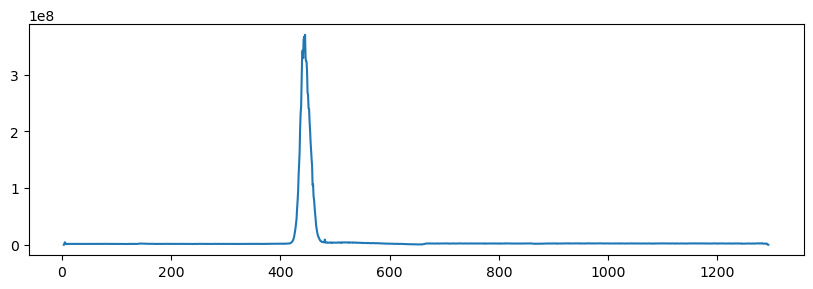

In [2]:
chrom_data = get_chrom_mzdb("../demo_data/180205_Poo_TruePoo_Full1.raw.mzDB", 118.0865, 10)
plt.plot(chrom_data["rt"], chrom_data["int"])

## Spectrum extraction

<StemContainer object of 3 artists>

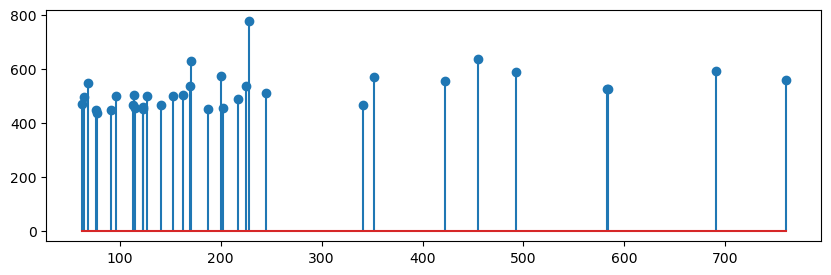

In [3]:
spec_data = get_spec_mzdb("../demo_data/180205_Poo_TruePoo_Full1.raw.mzDB", 1)
plt.stem(spec_data["mz"], spec_data["int"])

## RT range extraction

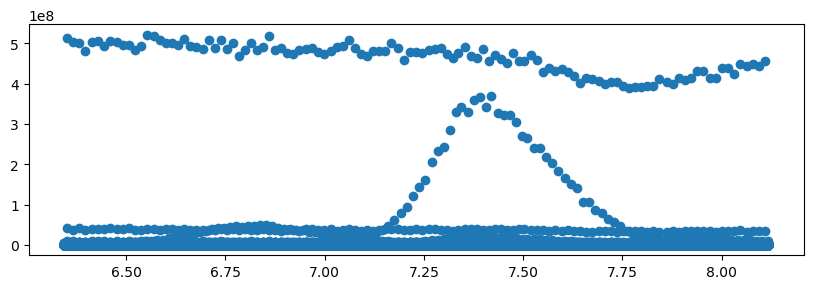

In [4]:
rtrange_data = get_rtrange_mzdb("../demo_data/180205_Poo_TruePoo_Full1.raw.mzDB", 6.5, 8)
plt.scatter(rtrange_data["rt"], rtrange_data["int"])

## Timing things

In [5]:
import timeit
mzml_spec = timeit.repeat('get_spec_mzml_pyteomics("../demo_data/180205_Poo_TruePoo_Full1.mzML", 1)', globals=globals(), number=1, repeat=10)
mzdb_spec = timeit.repeat('get_spec_mzdb("../demo_data/180205_Poo_TruePoo_Full1.raw.mzDB", 1)', globals=globals(), number=1, repeat=10)

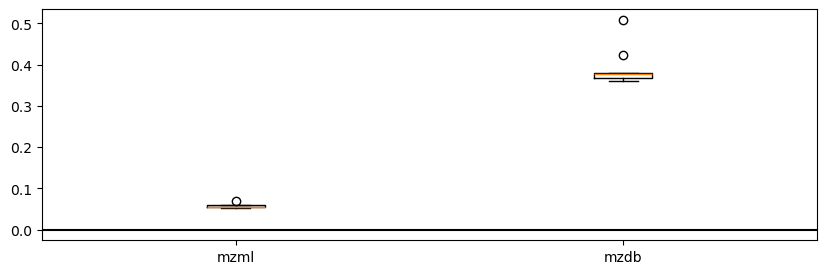

In [6]:
plt.boxplot([mzml_spec, mzdb_spec], tick_labels=["mzml", "mzdb"])
plt.axhline(y=0, color="k")
plt.show()

In [7]:
mzml_chrom = timeit.repeat('get_chrom_mzml_pyteomics("../demo_data/180205_Poo_TruePoo_Full1.mzML", 118.0865, 10)', globals=globals(), number=1, repeat=10)
mzdb_chrom = timeit.repeat('get_chrom_mzdb("../demo_data/180205_Poo_TruePoo_Full1.raw.mzDB", 118.0865, 10)', globals=globals(), number=1, repeat=10)

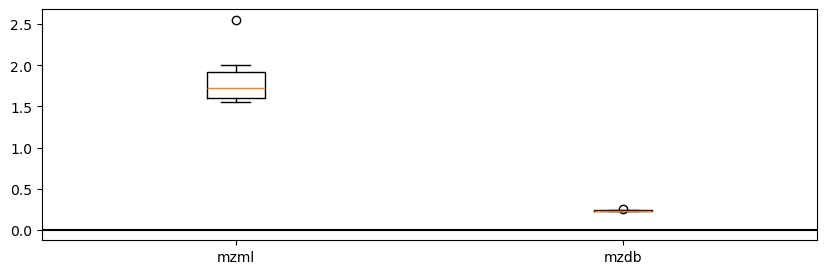

In [8]:
plt.boxplot([mzml_chrom, mzdb_chrom], tick_labels=["mzml", "mzdb"])
plt.axhline(y=0, color="k")
plt.show()

In [9]:
mzml_rtrange = timeit.repeat('get_rtrange_mzml_pyteomics("../demo_data/180205_Poo_TruePoo_Full1.mzML", 6.5, 8)', globals=globals(), number=1, repeat=10)
mzdb_rtrange = timeit.repeat('get_rtrange_mzdb("../demo_data/180205_Poo_TruePoo_Full1.raw.mzDB", 6.5, 8)', globals=globals(), number=1, repeat=10)

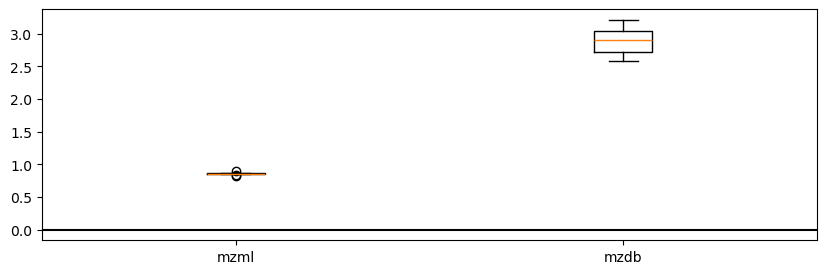

In [10]:
plt.boxplot([mzml_rtrange, mzdb_rtrange], tick_labels=["mzml", "mzdb"])
plt.axhline(y=0, color="k")
plt.show()

### Writing timing data out to file

In [11]:
import pandas as pd
rtrange_df = pd.DataFrame({
    "method": ["pyteomics"]*10 + ["mzdb"]*10,
    "time": mzml_rtrange + mzdb_rtrange
})
rtrange_df["metric"] = "rtrange"
spec_df = pd.DataFrame({
    "method": ["pyteomics"]*10 + ["mzdb"]*10,
    "time": mzml_spec + mzdb_spec
})
spec_df["metric"] = "spec"
chrom_df = pd.DataFrame({
    "method": ["pyteomics"]*10 + ["mzdb"]*10,
    "time": mzml_chrom + mzdb_chrom
})
chrom_df["metric"] = "chrom"

complete_timings = pd.concat([spec_df, chrom_df, rtrange_df], ignore_index=True)
complete_timings["datetime"] = pd.to_datetime('now')
complete_timings.to_csv("compiled_timings.csv", mode='a', index=False, header=False)

## Debugging file conversion and associated problems

In [12]:
connection = sqlite3.connect("../demo_data/180205_Poo_TruePoo_Full1.mzDB")

In [13]:
cursor = connection.cursor()

In [14]:
v = cursor.execute("SELECT id, mode, compression, byte_order, mz_precision, intensity_precision FROM data_encoding")
[row for row in v]

[(6, 'centroid', 'none', 'little_endian', 64, 32)]

In [15]:
scanid_rt_pd = pd.read_sql("SELECT id AS scan_id, time AS rt, ms_level FROM spectrum", connection)

bb_query = """
SELECT bounding_box.id, begin_mz, end_mz, first_spectrum_id, last_spectrum_id, time AS first_spectrum_time, data
FROM run_slice, bounding_box, spectrum
WHERE bounding_box.run_slice_id = run_slice.id
AND bounding_box.first_spectrum_id = spectrum.id
AND begin_mz = 115.0
"""

bb_dataframe = pd.read_sql(bb_query, connection)
unpacked_bb_list = [unpack_raw_bb(bb_data) for bb_data in bb_dataframe["data"]]
bb_chrom = pd.concat(unpacked_bb_list).merge(scanid_rt_pd)

bb_chrom

,mz,int,scan_id,rt,ms_level
0,115.073049,3.649322e+03,3.0,2.695467,1
1,117.081108,3.479283e+03,3.0,2.695467,1
2,119.681974,5.134103e+03,3.0,2.695467,1
3,115.084500,4.828643e+04,4.0,3.700448,1
4,117.558381,4.154451e+04,4.0,3.700448,1
...,...,...,...,...,...
14256,117.559966,2.552463e+05,1362.0,1293.167480,1
14257,118.069912,1.546971e+06,1362.0,1293.167480,1
14258,118.086517,6.597795e+04,1362.0,1293.167480,1
14259,119.068718,1.250914e+05,1362.0,1293.167480,1


In [16]:
mzmin, mzmax = pmppm(118.0865, 10)
chrom_data = bb_chrom[(mzmin < bb_chrom["mz"]) & (bb_chrom["mz"] < mzmax)]

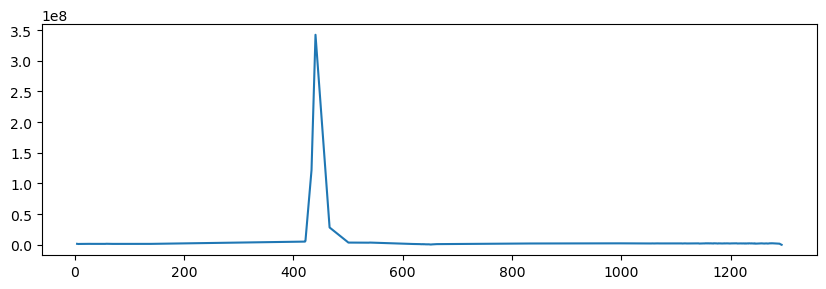

In [17]:
plt.plot(chrom_data["rt"], chrom_data["int"])

Seems like there's just missing data somehow??

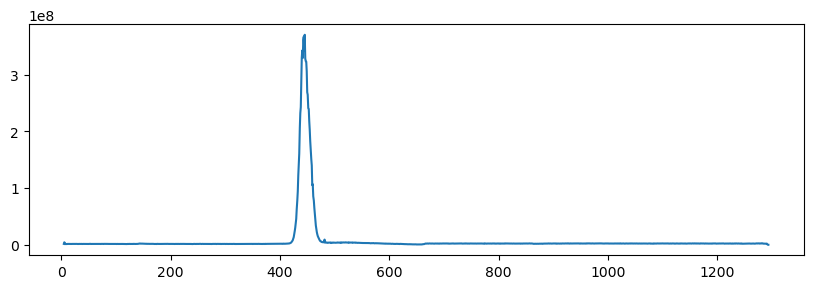

In [18]:
mzmin, mzmax = pmppm(118.0865, 100)
chrom_data = bb_chrom[(mzmin < bb_chrom["mz"]) & (bb_chrom["mz"] < mzmax)]
plt.plot(chrom_data["rt"], chrom_data["int"])

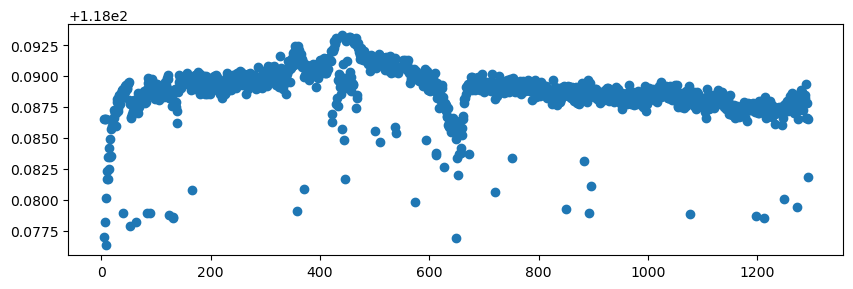

In [19]:
plt.scatter(chrom_data["rt"], chrom_data["mz"])

Missing data is due to really inaccurate masses, oof. mzML conversion in generally seems to be fully broken and the dev says that it probably won't be updated any more (https://github.com/mzdb/pwiz-mzdb/issues/70).

I don't remember what settings I had for this initially but I'm pretty sure I just went with the defaults which may have coerced it to their "fitted" mode?? However the metadata implies that it was kept in centroid mode. Trying again with 

`raw2mzDB.exe -i "C:\Users\willi\Desktop\180205_Poo_TruePoo_Full1.mzML" --centroid 1`

to force centroiding of MS1 data and can confirm that both input and output modes are centroided. Attempting this resulted in the same thing as before. Maybe if we go back to the .raw file we can perform the centroiding during the process? Unclear how I can separate the polarities this way though...

`raw2mzDB.exe -i "C:\Users\willi\Desktop\180205_Poo_TruePoo_Full1.raw" --centroid 1`

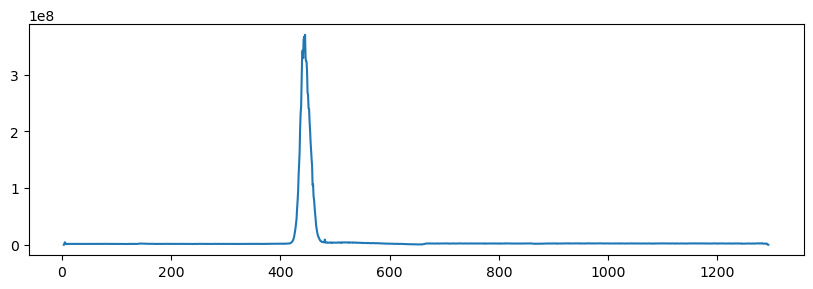

In [20]:
connection = sqlite3.connect("../demo_data/180205_Poo_TruePoo_Full1.raw.mzDB")
cursor = connection.cursor()

scanid_rt_pd = pd.read_sql("SELECT id AS scan_id, time AS rt, ms_level FROM spectrum", connection)

bb_query = """
SELECT bounding_box.id, begin_mz, end_mz, first_spectrum_id, time AS first_spectrum_time, data
FROM run_slice, bounding_box, spectrum
WHERE bounding_box.run_slice_id = run_slice.id
AND bounding_box.first_spectrum_id = spectrum.id
AND begin_mz = ?
"""

bb_dataframe = pd.read_sql(bb_query, connection, params=(115.0,))
unpacked_bb_list = [unpack_raw_bb(bb_data) for bb_data in bb_dataframe["data"]]
bb_chrom = pd.concat(unpacked_bb_list).merge(scanid_rt_pd)

mzmin, mzmax = pmppm(118.0865, 10)
chrom_data = bb_chrom[(mzmin < bb_chrom["mz"]) & (bb_chrom["mz"] < mzmax)]
plt.plot(chrom_data["rt"], chrom_data["int"])

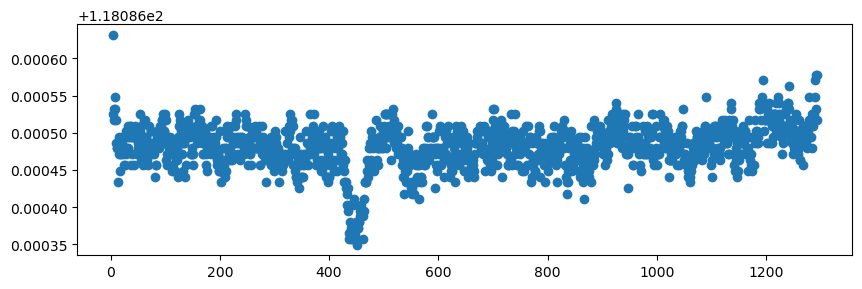

In [21]:
plt.scatter(chrom_data["rt"], chrom_data["mz"])

Ok, that seems to work - so they have to get converted from .raw instead of .mzML. That kinda sucks and I don't know how to separate out pos and neg polarities in that case.